In [1]:
#imports
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus

#pandas profiling
from pandas_profiling import ProfileReport

#sklearn stuff
from sklearn.pipeline import Pipeline
from feature_engine.discretisers import EqualFrequencyDiscretiser
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC

%matplotlib inline

In [2]:
# Import the Dataset
data = pd.read_csv('Credit_Data.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,female,university,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,default
1,2,120000,female,university,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,default
2,3,90000,female,university,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
3,4,50000,female,university,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
4,5,50000,male,university,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,not default


In [3]:
# Rename column
data['Default'] = data['default payment next month']
# Drop unneeded columns
data = data.drop(['ID', 'default payment next month'], axis=1)

In [4]:
# Drop duplicate rows
data = data.drop_duplicates()

# Check for nulls
nulls = data.isnull().sum()
nulls

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Default      0
dtype: int64

In [5]:
# Check datatypes
data.dtypes

LIMIT_BAL     int64
SEX          object
EDUCATION    object
MARRIAGE      int64
AGE           int64
PAY_0         int64
PAY_2         int64
PAY_3         int64
PAY_4         int64
PAY_5         int64
PAY_6         int64
BILL_AMT1     int64
BILL_AMT2     int64
BILL_AMT3     int64
BILL_AMT4     int64
BILL_AMT5     int64
BILL_AMT6     int64
PAY_AMT1      int64
PAY_AMT2      int64
PAY_AMT3      int64
PAY_AMT4      int64
PAY_AMT5      int64
PAY_AMT6      int64
Default      object
dtype: object

In [6]:
# Encode as needed
le = LabelEncoder()
le.fit(data['SEX'])
data['SEX'] = le.transform(data['SEX'])

In [7]:
# Encode as needed
le = LabelEncoder()
le.fit(data['Default'])
data['Default'] = le.transform(data['Default'])

In [8]:
# One-hot encode objects
data = pd.get_dummies(data)

In [9]:
# Check datatypes
data.dtypes

LIMIT_BAL                    int64
SEX                          int32
MARRIAGE                     int64
AGE                          int64
PAY_0                        int64
PAY_2                        int64
PAY_3                        int64
PAY_4                        int64
PAY_5                        int64
PAY_6                        int64
BILL_AMT1                    int64
BILL_AMT2                    int64
BILL_AMT3                    int64
BILL_AMT4                    int64
BILL_AMT5                    int64
BILL_AMT6                    int64
PAY_AMT1                     int64
PAY_AMT2                     int64
PAY_AMT3                     int64
PAY_AMT4                     int64
PAY_AMT5                     int64
PAY_AMT6                     int64
Default                      int32
EDUCATION_graduate school    uint8
EDUCATION_high school        uint8
EDUCATION_other              uint8
EDUCATION_university         uint8
dtype: object

In [10]:
# View the makeup of the data
data.describe()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,0.396262,1.551877,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,-0.289438,...,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.778742,0.352511,0.164025,0.015618,0.467846
std,129760.135222,0.489128,0.521997,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,1.149090,...,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101,0.477760,0.370304,0.123995,0.498973
min,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,8.500000e+02,390.000000,300.000000,261.000000,131.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,140000.000000,0.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,240000.000000,1.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1000000.000000,1.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are 29,965 distinct customer loans
The average credit limit is 167,442, minimum credit limit is 10,000 and max is 1,000,000
Education level is mostly graduate school and university
Average age is 35.5 with a standard deviation of 9.2
There are 22% of customer loans that will default next month

In [11]:
# Shift pay features for -2
data['PAY_0'] = data['PAY_0'].replace(-2,0)
data['PAY_2'] = data['PAY_2'].replace(-2,0)
data['PAY_3'] = data['PAY_3'].replace(-2,0)
data['PAY_4'] = data['PAY_4'].replace(-2,0)
data['PAY_5'] = data['PAY_5'].replace(-2,0)
data['PAY_6'] = data['PAY_6'].replace(-2,0)

# Shift pay features for -1
data['PAY_0'] = data['PAY_0'].replace(-1,0)
data['PAY_2'] = data['PAY_2'].replace(-1,0)
data['PAY_3'] = data['PAY_3'].replace(-1,0)
data['PAY_4'] = data['PAY_4'].replace(-1,0)
data['PAY_5'] = data['PAY_5'].replace(-1,0)
data['PAY_6'] = data['PAY_6'].replace(-1,0)

In [12]:
data.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university
0,20000,0,1,24,2,2,0,0,0,0,...,689,0,0,0,0,0,0,0,0,1
1,120000,0,2,26,0,2,0,0,0,2,...,1000,1000,1000,0,2000,0,0,0,0,1
2,90000,0,2,34,0,0,0,0,0,0,...,1500,1000,1000,1000,5000,1,0,0,0,1
3,50000,0,1,37,0,0,0,0,0,0,...,2019,1200,1100,1069,1000,1,0,0,0,1
4,50000,1,1,57,0,0,0,0,0,0,...,36681,10000,9000,689,679,1,0,0,0,1


In [13]:
# Check the correlations of the variables
data.corr()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university
LIMIT_BAL,1.000000,-0.025015,-0.108081,0.144643,-0.170975,-0.197039,-0.191185,-0.180492,-0.169903,-0.167674,...,0.178584,0.210375,0.203451,0.217421,0.219807,0.153871,0.258512,-0.139583,0.013468,-0.147280
SEX,-0.025015,1.000000,0.031372,0.091057,0.034612,0.044685,0.041064,0.039565,0.038349,0.031869,...,0.001390,0.008599,0.002227,0.001665,0.002765,-0.039742,0.022890,0.007807,-0.008502,-0.025598
MARRIAGE,-0.108081,0.031372,1.000000,-0.413901,-0.011770,-0.010001,0.000565,-0.004201,-0.002941,0.001885,...,-0.008099,-0.003545,-0.012668,-0.001207,-0.006646,0.024019,0.142187,-0.110925,-0.008393,-0.051735
AGE,0.144643,0.091057,-0.413901,1.000000,-0.001401,-0.008783,-0.014171,-0.007167,-0.013141,-0.016816,...,0.021726,0.029181,0.021306,0.022777,0.019409,-0.013619,-0.100403,0.231322,0.008952,-0.077762
PAY_0,-0.170975,0.034612,-0.011770,-0.001401,1.000000,0.698771,0.517209,0.460391,0.424593,0.373883,...,-0.057092,-0.062507,-0.061768,-0.053659,-0.048616,-0.396200,-0.068575,0.042082,-0.025403,0.040742
PAY_2,-0.197039,0.044685,-0.010001,-0.008783,0.698771,1.000000,0.663434,0.512599,0.462524,0.406853,...,-0.054946,-0.059989,-0.054108,-0.048843,-0.043218,-0.327095,-0.083326,0.043769,-0.038228,0.056801
PAY_3,-0.191185,0.041064,0.000565,-0.014171,0.517209,0.663434,1.000000,0.678639,0.551006,0.492344,...,-0.073776,-0.057812,-0.053961,-0.050916,-0.048547,-0.286898,-0.071400,0.041765,-0.041327,0.047639
PAY_4,-0.180492,0.039565,-0.004201,-0.007167,0.460391,0.512599,0.678639,1.000000,0.745171,0.602485,...,-0.036951,-0.074166,-0.055400,-0.052827,-0.048917,-0.268937,-0.067921,0.039347,-0.036484,0.044898
PAY_5,-0.169903,0.038349,-0.002941,-0.013141,0.424593,0.462524,0.551006,0.745171,1.000000,0.740088,...,-0.039651,-0.037341,-0.066032,-0.051898,-0.046185,-0.260721,-0.057033,0.029220,-0.035144,0.041656
PAY_6,-0.167674,0.031869,0.001885,-0.016816,0.373883,0.406853,0.492344,0.602485,0.740088,1.000000,...,-0.039936,-0.040236,-0.030532,-0.066969,-0.045436,-0.244290,-0.046825,0.020000,-0.034644,0.038601


The repayment status variables PAY_0 - PAY_6 have the highest correlation in the dataset with customer defaults.

In [14]:
# Rename column PAY_0 to PAY_1
data = data.rename(columns={'PAY_0': 'PAY_1'})
data.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university
0,20000,0,1,24,2,2,0,0,0,0,...,689,0,0,0,0,0,0,0,0,1
1,120000,0,2,26,0,2,0,0,0,2,...,1000,1000,1000,0,2000,0,0,0,0,1
2,90000,0,2,34,0,0,0,0,0,0,...,1500,1000,1000,1000,5000,1,0,0,0,1
3,50000,0,1,37,0,0,0,0,0,0,...,2019,1200,1100,1069,1000,1,0,0,0,1
4,50000,1,1,57,0,0,0,0,0,0,...,36681,10000,9000,689,679,1,0,0,0,1


In [15]:
# Rename education columns
data = data.rename(columns={'EDUCATION_graduate school':'Grad School', 'EDUCATION_high school':'High School',
                           'EDUCATION_other':'Edu_Other', 'EDUCATION_university':'University'})
data.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,Grad School,High School,Edu_Other,University
0,20000,0,1,24,2,2,0,0,0,0,...,689,0,0,0,0,0,0,0,0,1
1,120000,0,2,26,0,2,0,0,0,2,...,1000,1000,1000,0,2000,0,0,0,0,1
2,90000,0,2,34,0,0,0,0,0,0,...,1500,1000,1000,1000,5000,1,0,0,0,1
3,50000,0,1,37,0,0,0,0,0,0,...,2019,1200,1100,1069,1000,1,0,0,0,1
4,50000,1,1,57,0,0,0,0,0,0,...,36681,10000,9000,689,679,1,0,0,0,1


In [16]:
# Fix values for the variable SEX (1=male; 2=female)
data['SEX'] = data['SEX'].replace(0,2)
data.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,Grad School,High School,Edu_Other,University
0,20000,2,1,24,2,2,0,0,0,0,...,689,0,0,0,0,0,0,0,0,1
1,120000,2,2,26,0,2,0,0,0,2,...,1000,1000,1000,0,2000,0,0,0,0,1
2,90000,2,2,34,0,0,0,0,0,0,...,1500,1000,1000,1000,5000,1,0,0,0,1
3,50000,2,1,37,0,0,0,0,0,0,...,2019,1200,1100,1069,1000,1,0,0,0,1
4,50000,1,1,57,0,0,0,0,0,0,...,36681,10000,9000,689,679,1,0,0,0,1


In [17]:
# Fix values for the variable default (Yes=1; No=0)
data['Default'] = data['Default'].replace(1,2)

In [18]:
data['Default'] = data['Default'].replace(0,1)

In [19]:
data['Default'] = data['Default'].replace(2,0)
data.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,Grad School,High School,Edu_Other,University
0,20000,2,1,24,2,2,0,0,0,0,...,689,0,0,0,0,1,0,0,0,1
1,120000,2,2,26,0,2,0,0,0,2,...,1000,1000,1000,0,2000,1,0,0,0,1
2,90000,2,2,34,0,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,0,0,0,1
3,50000,2,1,37,0,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,0,0,0,1
4,50000,1,1,57,0,0,0,0,0,0,...,36681,10000,9000,689,679,0,0,0,0,1


All datatypes have been changed to numeric values, duplicate and unwanted rows have been removed, education level has been split into separate variables, all value labels for SEX and default have been changed to match the Data Set and Attribute Information Source provided by I-Cheng Yeh, all -2 and -1 value labels for PAY_1 - PAY_6 have been grouped with the 0 value label to represent a duly paid status.

In [20]:
# Save the cleaned dataset in a csv file
data.to_csv('Credit_Cleaned.csv', index=False)

In [21]:
# Import the cleaned Dataset for EDA
data = pd.read_csv('Credit_Cleaned.csv')
data.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,Grad School,High School,Edu_Other,University
0,20000,2,1,24,2,2,0,0,0,0,...,689,0,0,0,0,1,0,0,0,1
1,120000,2,2,26,0,2,0,0,0,2,...,1000,1000,1000,0,2000,1,0,0,0,1
2,90000,2,2,34,0,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,0,0,0,1
3,50000,2,1,37,0,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,0,0,0,1
4,50000,1,1,57,0,0,0,0,0,0,...,36681,10000,9000,689,679,0,0,0,0,1


In [22]:
# Start with the target variable (default)
data.Default.value_counts()

0    23335
1     6630
Name: Default, dtype: int64

In [23]:
# Defaults by Sex
data.groupby('Default')['SEX'].value_counts()

Default  SEX
0        2      14330
         1       9005
1        2       3761
         1       2869
Name: SEX, dtype: int64

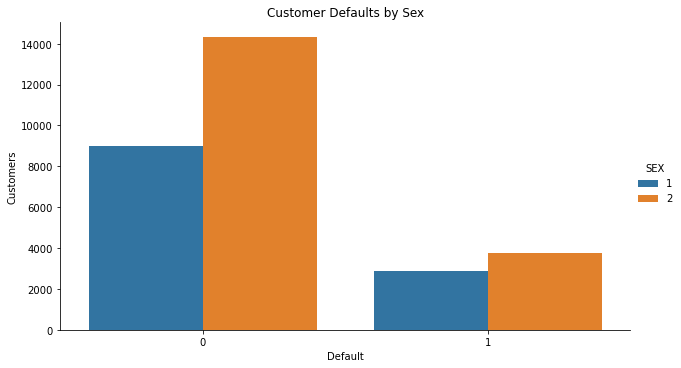

In [24]:
# Seaborn Cat Plot of Defaults by SEX
g = sns.catplot('Default', data=data, hue='SEX', kind='count', aspect=1.75)
g.set_xlabels('Default')
g.set_ylabels('Customers')
g.set(title='Customer Defaults by Sex');

60% of customers are female.

In [25]:
# Lets look at the probability to default by Sex
data[['SEX', 'Default']].groupby(['SEX'], as_index=False).mean().sort_values(by='Default', ascending=False)

,SEX,Default
0,1,0.241620
1,2,0.207893


Almost 25% of male customers default compared to 20% of female customers.

In [26]:
# Defaults by Marital status
data.groupby('Default')['MARRIAGE'].value_counts()

Default  MARRIAGE
0        2           12605
         1           10442
         3             239
         0              49
1        2            3340
         1            3201
         3              84
         0               5
Name: MARRIAGE, dtype: int64

Looks like we should combine the 0 and 3 labels for divorced and other to make them all 3 and defined as 'other' marital status.

In [27]:
# Combine the 0 and 3 labels for divorced and other and make them a label 3
data.loc[data.MARRIAGE == 0, 'MARRIAGE'] = 3
data.MARRIAGE.value_counts()

2    15945
1    13643
3      377
Name: MARRIAGE, dtype: int64

53% of customers are single, 46% are married, and only 1% are divorced or other.

In [28]:
# Defaults by Marital status Re-grouped
data.groupby('Default')['MARRIAGE'].value_counts()

Default  MARRIAGE
0        2           12605
         1           10442
         3             288
1        2            3340
         1            3201
         3              89
Name: MARRIAGE, dtype: int64

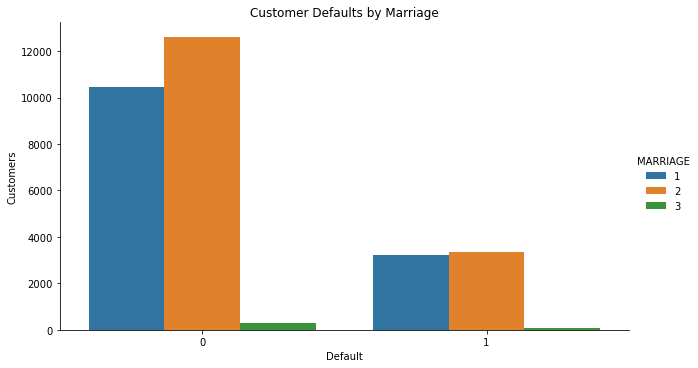

In [29]:
# Seaborn Cat Plot of Defaults by Marriage
g = sns.catplot('Default', data=data, hue='MARRIAGE', kind='count', aspect=1.75)
g.set_xlabels('Default')
g.set_ylabels('Customers')
g.set(title='Customer Defaults by Marriage');

Marriage does not appear to be a relevant factor for defaults but lets dive a little deeper in the data first.

In [30]:
# Create a function that gives the percentage of variable x when compared to variable y
def perc_2_vars(Col1, Col2):
    df = data.groupby([Col1, Col2]).size().unstack()
    df['Perc'] = (df[df.columns[1]]/(df[df.columns[0]] + df[df.columns[1]]))
    return df

In [31]:
perc_2_vars('MARRIAGE', 'Default')

Default,0,1,Perc
MARRIAGE,,,
1,10442,3201,0.234626
2,12605,3340,0.209470
3,288,89,0.236074


Married customers are more likely to default than single customers, the 'other' label (3) will not have much weight in the final result.

In [32]:
# Customer Defaults by Sex and Marriage
data.groupby(['SEX', 'MARRIAGE'])['Default'].value_counts()

SEX  MARRIAGE  Default
1    1         0          3841
               1          1343
     2         0          5061
               1          1484
     3         0           103
               1            42
2    1         0          6601
               1          1858
     2         0          7544
               1          1856
     3         0           185
               1            47
Name: Default, dtype: int64

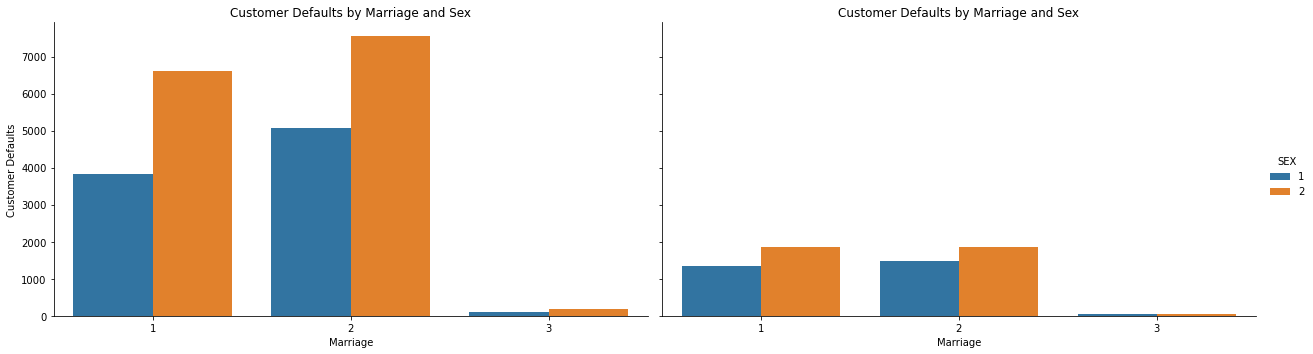

In [33]:
# Seaborn Cat Plot of Customer Defaults by Sex and Marriage
g = sns.catplot('MARRIAGE', data=data, hue='SEX', kind='count', col='Default', aspect=1.75)
g.set_xlabels('Marriage')
g.set_ylabels('Customer Defaults')
g.set(title='Customer Defaults by Marriage and Sex');

In [34]:
# Check the variable Age
data['AGE'].describe()

count    29965.000000
mean        35.487969
std          9.219459
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

The age range is 21 to 79 with an average of 35.5 and a standard deviation of 9.2.

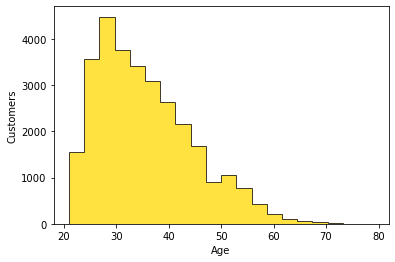

In [35]:
# Histogram of Customers by Age
a = data['AGE']
plt.hist(a, bins=20, density=False, alpha=0.75, histtype='stepfilled', color='gold', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Customers');

Ages 28 to 31 have the highest number of customers.

In [36]:
# Discretize Age using 4 bins (<29, 29-35, 36-45, >45)
data['Age_Disc'] = pd.cut(data['AGE'], bins=[20,28,35,45,80], labels=['<29','29-35','36-45','>45'])
data.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,Grad School,High School,Edu_Other,University,Age_Disc
0,20000,2,1,24,2,2,0,0,0,0,...,0,0,0,0,1,0,0,0,1,<29
1,120000,2,2,26,0,2,0,0,0,2,...,1000,1000,0,2000,1,0,0,0,1,<29
2,90000,2,2,34,0,0,0,0,0,0,...,1000,1000,1000,5000,0,0,0,0,1,29-35
3,50000,2,1,37,0,0,0,0,0,0,...,1200,1100,1069,1000,0,0,0,0,1,36-45
4,50000,1,1,57,0,0,0,0,0,0,...,10000,9000,689,679,0,0,0,0,1,>45


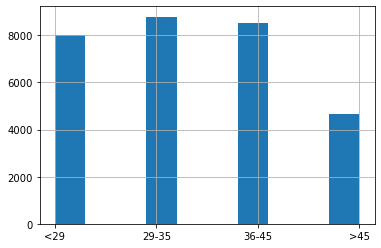

In [37]:
# Histogram of Age Bins
data['Age_Disc'].hist()

In [38]:
perc_2_vars('Age_Disc', 'Default')

Default,0,1,Perc
Age_Disc,,,
<29,6118,1883,0.235346
29-35,7073,1713,0.194969
36-45,6656,1856,0.218045
>45,3488,1178,0.252465


Customers 29-35 have the lowest default percentage while customers over 45 have the highest.

In [39]:
# Customer Defaults by Age and Sex
table = pd.crosstab(index=[data.Default, data.Age_Disc], columns=[data.SEX])

table.unstack()

SEX          1                       2                  
Age_Disc   <29 29-35 36-45   >45   <29 29-35 36-45   >45
Default                                                 
0         1999  2728  2696  1582  4119  4345  3960  1906
1          660   755   879   575  1223   958   977   603

Default percentage for Sex by Age:
Male <29 = 25%, 29-35 = 22%, 36-45 = 25%, >45 = 27%
Female <29 = 23%, 29-35 = 18%, 36-45 = 20%, >45 = 24%

Male customers over 45 have the highest default percentage, while Female customers 29-35 have the lowest.
Male customers are more likely to default in all ages.

In [40]:
# Customer Defaults by Age and Marital status
table = pd.crosstab(index=[data.Default, data.Age_Disc], columns=[data.MARRIAGE])

table.unstack()

MARRIAGE    1                       2                    3                 
Age_Disc  <29 29-35 36-45   >45   <29 29-35 36-45  >45 <29 29-35 36-45  >45
Default                                                                    
0         824  2559  4511  2548  5269  4465  2035  836  25    49   110  104
1         321   712  1264   904  1551   991   566  232  11    10    26   42

Married customers under 29 and over 45 are most likely to default, with the exception of 'other' marital status in same ages.

In [41]:
# Customer Defaults by Marital status and Sex
table = pd.crosstab(index=[data.Default, data.MARRIAGE], columns=[data.SEX])

table.unstack()

SEX          1                2           
MARRIAGE     1     2    3     1     2    3
Default                                   
0         3841  5061  103  6601  7544  185
1         1343  1484   42  1858  1856   47

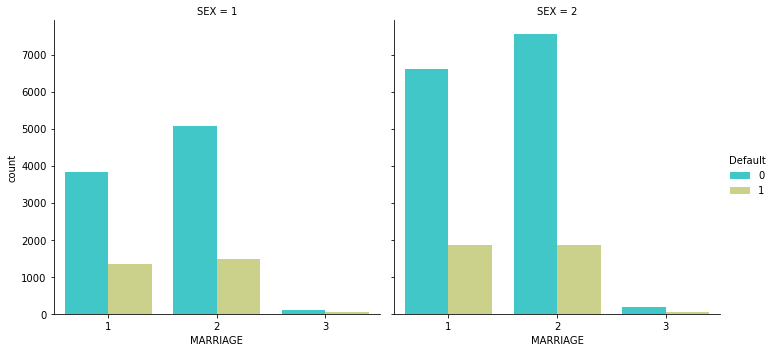

In [43]:
# Seaborn factor plot of Defaults by Sex and Marital Status
sns.factorplot('MARRIAGE', data=data, hue='Default', kind='count', palette='rainbow', col='SEX');

Male customers that are married and 'other' have by far the highest percentage to default. So far, male customers over 45 that are not single are most likely to default, while female customers 29-45 and not married are most likely not to default.

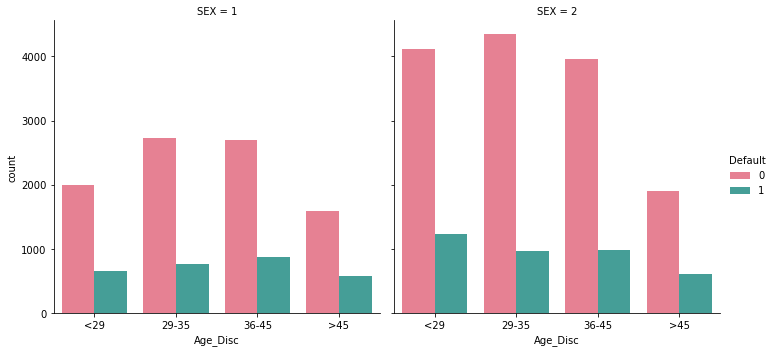

In [44]:
# Seaborn factor plot of Defaults by Sex and Age
sns.factorplot('Age_Disc', data=data, hue='Default', kind='count', palette='husl', col='SEX');

In [45]:
# Check Education level
data['Grad School'].value_counts()

0    19402
1    10563
Name: Grad School, dtype: int64

In [46]:
# Check Education level
data['High School'].value_counts()

0    25050
1     4915
Name: High School, dtype: int64

In [47]:
# Check Education level
data['University'].value_counts()

0    15946
1    14019
Name: University, dtype: int64

In [48]:
# Check Education level
data['Edu_Other'].value_counts()

0    29497
1      468
Name: Edu_Other, dtype: int64

82% of customers have an education level of Grad School or University. We have some options with the High School and Other variables. We could combine them into one variable or delete Other completely. I will keep this in mind for feature selection.

In [49]:
perc_2_vars('Grad School', 'Default')

Default,0,1,Perc
Grad School,,,
0,14804,4598,0.236986
1,8531,2032,0.192370


In [50]:
perc_2_vars('High School', 'Default')

Default,0,1,Perc
High School,,,
0,19657,5393,0.215289
1,3678,1237,0.251679


In [51]:
perc_2_vars('University', 'Default')

Default,0,1,Perc
University,,,
0,12644,3302,0.207074
1,10691,3328,0.237392


In [52]:
perc_2_vars('Edu_Other', 'Default')

Default,0,1,Perc
Edu_Other,,,
0,22900,6597,0.223650
1,435,33,0.070513


Customers with a High School education level are most likely to default. Side note: only 33 of 468 customers with an 'other' education level default (7%). Not sure what to think about this variable, might give our model probelms but the instances are so small in number probably wouldnt have much affect.

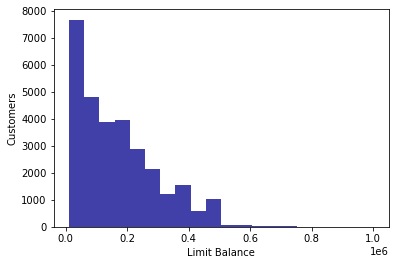

In [53]:
# Check Limit Balance
# Histogram of Customers by Limit Balance
a = data['LIMIT_BAL']
plt.hist(a, bins=20, density=False, alpha=0.75, histtype='stepfilled', color='darkblue', edgecolor='none')
plt.xlabel('Limit Balance')
plt.ylabel('Customers');

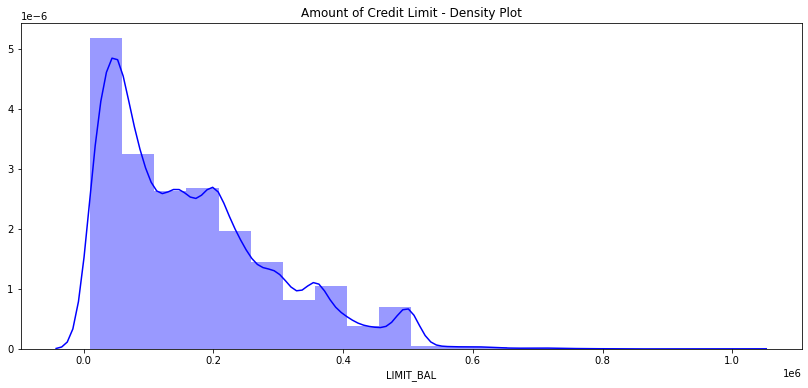

In [54]:
plt.figure(figsize = (14,6))
plt.title('Amount of Credit Limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data['LIMIT_BAL'],kde=True,bins=20, color="blue")
plt.show()

In [55]:
# Check number of distinct values for Limit Balance
data['LIMIT_BAL'].value_counts().shape

(81,)

In [56]:
data['LIMIT_BAL'].value_counts().head(5)

50000     3363
20000     1975
30000     1610
80000     1564
200000    1524
Name: LIMIT_BAL, dtype: int64

Loans with a $50,000 credit limit have the highest number of customer accounts.

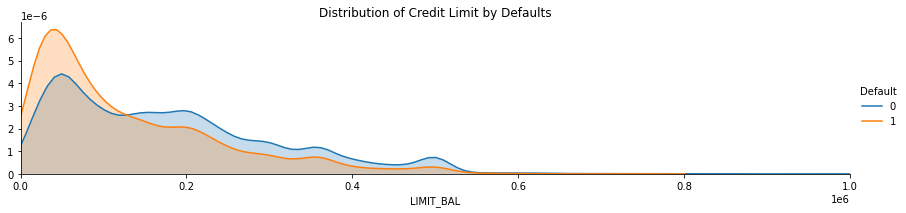

In [57]:
# Kde Distribution Plot of Limit Balance by Default
fig = sns.FacetGrid(data, hue='Default', aspect=4)
fig.map(sns.kdeplot, 'LIMIT_BAL', shade=True)
amax = data['LIMIT_BAL'].max()
fig.set(xlim=(0,amax))
fig.set(title='Distribution of Credit Limit by Defaults')
fig.add_legend();

There are more defaults than not defaults for credit limits under $150,000. Looks like credit limits around 30 - 50k have the highest percentage of defaults to loans in the dataset. This is interesting because those were the limit amounts with the highest number of customer accounts.

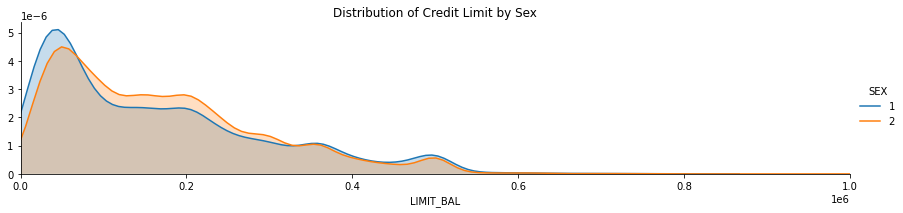

In [58]:
# Kde Distribution Plot of Limit Balance by Sex
fig = sns.FacetGrid(data, hue='SEX', aspect=4)
fig.map(sns.kdeplot, 'LIMIT_BAL', shade=True)
amax = data['LIMIT_BAL'].max()
fig.set(xlim=(0,amax))
fig.set(title='Distribution of Credit Limit by Sex')
fig.add_legend();

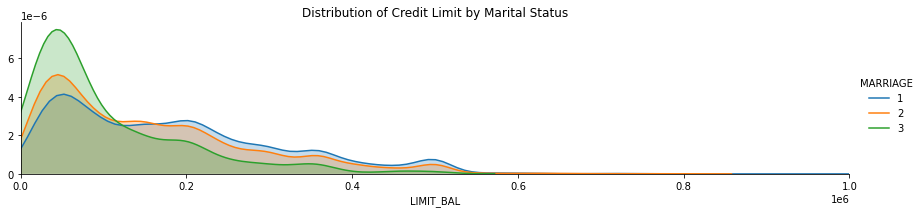

In [59]:
# Kde Distribution Plot of Limit Balance by Marital Status
fig = sns.FacetGrid(data, hue='MARRIAGE', aspect=4)
fig.map(sns.kdeplot, 'LIMIT_BAL', shade=True)
amax = data['LIMIT_BAL'].max()
fig.set(xlim=(0,amax))
fig.set(title='Distribution of Credit Limit by Marital Status')
fig.add_legend();

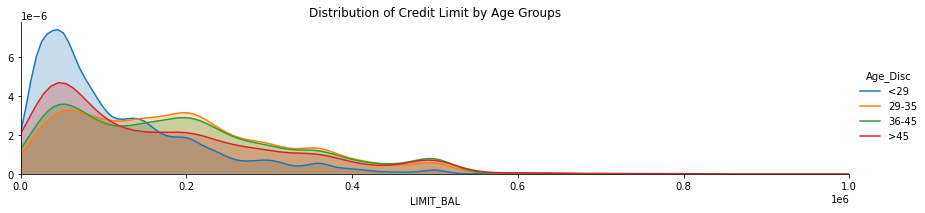

In [60]:
# Kde Distribution Plot of Limit Balance by Age Bins
fig = sns.FacetGrid(data, hue='Age_Disc', aspect=4)
fig.map(sns.kdeplot, 'LIMIT_BAL', shade=True)
amax = data['LIMIT_BAL'].max()
fig.set(xlim=(0,amax))
fig.set(title='Distribution of Credit Limit by Age Groups')
fig.add_legend();

It seems that customers that are male, have a marital status of 'other', and are under 29 have the highest distribution of the credit limit amounts of 30-50k.

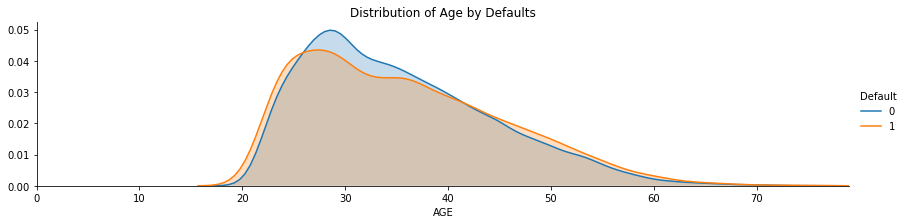

In [61]:
# Check the distribution of Age by Defaults
fig = sns.FacetGrid(data, hue='Default', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
amax = data['AGE'].max()
fig.set(xlim=(0,amax))
fig.set(title='Distribution of Age by Defaults')
fig.add_legend();

This tells me a lot. Customers under 25 and over 45 have more defaults than not defaults, while customers 26 to 41 are the only ages that have more not defaults than defaults. Customers 28 to 32 have the most credit loans and the lowest percentage to default. Customers under 25 and around 50 have the highest percentage to default.

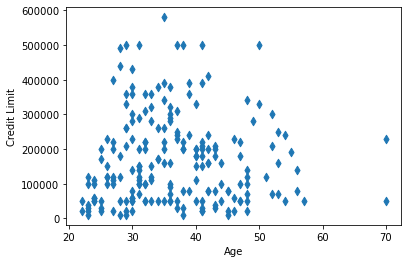

In [62]:
# Scatter Plot of Age vs Limit Balance
data_sample = data.sample(200)

x = data_sample['AGE']
y = data_sample['LIMIT_BAL']

plt.scatter(x, y, marker='d')
plt.xlabel('Age')
plt.ylabel('Credit Limit');

Now lets look into the payment and bill statement variables.

In [63]:
# Check the Pay Status
data[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].sample(20)

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
28200,0,0,0,0,0,0
535,0,0,0,0,0,0
5708,0,0,0,0,0,0
10166,0,0,0,0,0,0
29868,0,0,0,0,0,0
1219,0,0,0,0,0,0
13911,0,0,0,0,0,0
20426,0,0,0,0,0,0
23931,1,2,0,0,0,0
3389,1,2,0,0,0,0


This confuses me. How does a customer go from 0 (duly paid) to 2 (payment delay for 2 months)? Maybe the Pay and Bill amounts will shed some light on this.

In [64]:
data[['PAY_AMT6','BILL_AMT6','PAY_AMT5','BILL_AMT5','PAY_AMT4','BILL_AMT4','PAY_AMT3','BILL_AMT3','PAY_AMT2','BILL_AMT2',
     'PAY_AMT1','BILL_AMT1','LIMIT_BAL','Default']].sample(20)

,PAY_AMT6,BILL_AMT6,PAY_AMT5,BILL_AMT5,PAY_AMT4,BILL_AMT4,PAY_AMT3,BILL_AMT3,PAY_AMT2,BILL_AMT2,PAY_AMT1,BILL_AMT1,LIMIT_BAL,Default
13617,0,1687,1687,1643,1643,1930,1930,0,0,27415,27474,7363,250000,0
5875,3300,1133,231133,0,0,8164,8169,-5,0,-5,0,-5,280000,0
8494,0,410127,28000,394410,13560,392932,14000,391178,0,405016,405016,6500,400000,0
25245,1300,29823,1300,29146,1200,30619,1700,30593,2000,30554,2000,30523,30000,0
12742,0,0,0,8000,160,8620,172,8448,1000,13938,9200,5413,30000,0
19175,5000,133262,5000,129486,7000,123551,5000,119576,5000,116014,0,119432,200000,1
22675,6000,153107,6000,149920,6000,146363,6000,142744,6000,138994,5000,136264,200000,0
16270,201,1232,1234,1530,1532,11670,11728,6350,6364,13500,13551,12050,450000,0
13615,0,4187,1000,3395,0,3597,0,3800,0,4003,0,4205,10000,1
15459,31000,37371,0,43401,5000,43957,0,50104,3000,53306,1000,58908,120000,1


Interesting, how does a customer default when he has duly paid his bill every month?

Lets look at the last 2 payment amounts vs bill amounts and the payment status compared to limit balance and default status.

In [65]:
data[['BILL_AMT3','PAY_AMT2','BILL_AMT2','PAY_AMT1','BILL_AMT1','PAY_1','LIMIT_BAL','Default']].sample(20)

,BILL_AMT3,PAY_AMT2,BILL_AMT2,PAY_AMT1,BILL_AMT1,PAY_1,LIMIT_BAL,Default
5764,16733,1280,15722,1269,14692,0,90000,0
1723,6000,6000,0,0,13234,0,160000,0
25913,0,0,0,0,0,1,260000,0
9371,10467,2000,8692,5000,3811,0,130000,1
9950,1403,3290,12186,12253,3266,0,320000,0
12145,4050,1068,3193,1211,2004,0,20000,1
516,69188,3300,67629,3060,68739,0,70000,0
14983,476,0,674,674,229,0,260000,0
29151,28076,1752,27104,1780,26061,0,30000,0
12368,89583,4126,86901,3153,85119,0,140000,1


In [66]:
data[data.Default == 1][['BILL_AMT2','PAY_AMT1','BILL_AMT1','PAY_1','LIMIT_BAL']].sample(20)

,BILL_AMT2,PAY_AMT1,BILL_AMT1,PAY_1,LIMIT_BAL
11445,48621,0,50468,1,50000
1719,47990,0,49157,2,50000
5369,6968,0,7229,1,10000
23104,5899,5899,3948,0,230000
12696,49363,8,50953,3,50000
10929,109439,1308,113436,2,180000
25610,44347,2000,43357,2,70000
11049,3352,3352,3352,0,220000
19726,6233,0,6483,0,20000
18416,36449,1500,35845,2,50000


It seems customers are likely to default if Bill Amount 1 is close to their credit limit or Pay Amount 1 is too low to Bill Amount 2, although I already see some exceptions to this.

FEATURE ENGINEERING

In [67]:
# Combine the variables Sex and Marriage
data['SE_MA'] = 0
data.loc[((data.SEX == 1) & (data.MARRIAGE == 1)) , 'SE_MA'] = 1 # married man
data.loc[((data.SEX == 1) & (data.MARRIAGE == 2)) , 'SE_MA'] = 2 # single man
data.loc[((data.SEX == 1) & (data.MARRIAGE == 3)) , 'SE_MA'] = 3 # divorced/other man
data.loc[((data.SEX == 2) & (data.MARRIAGE == 1)) , 'SE_MA'] = 4 # married woman
data.loc[((data.SEX == 2) & (data.MARRIAGE == 2)) , 'SE_MA'] = 5 # single woman
data.loc[((data.SEX == 2) & (data.MARRIAGE == 3)) , 'SE_MA'] = 6 # divorced/other woman
perc_2_vars('SE_MA', 'Default')

Default,0,1,Perc
SE_MA,,,
1,3841,1343,0.259066
2,5061,1484,0.226738
3,103,42,0.289655
4,6601,1858,0.219648
5,7544,1856,0.197447
6,185,47,0.202586


In [68]:
# Check Data Types
data.dtypes

LIMIT_BAL         int64
SEX               int64
MARRIAGE          int64
AGE               int64
PAY_1             int64
PAY_2             int64
PAY_3             int64
PAY_4             int64
PAY_5             int64
PAY_6             int64
BILL_AMT1         int64
BILL_AMT2         int64
BILL_AMT3         int64
BILL_AMT4         int64
BILL_AMT5         int64
BILL_AMT6         int64
PAY_AMT1          int64
PAY_AMT2          int64
PAY_AMT3          int64
PAY_AMT4          int64
PAY_AMT5          int64
PAY_AMT6          int64
Default           int64
Grad School       int64
High School       int64
Edu_Other         int64
University        int64
Age_Disc       category
SE_MA             int64
dtype: object

We need to change Age Disc to numeric.

In [69]:
del data['Age_Disc']

In [70]:
# Discretize Age using 4 bins (<29, 29-35, 36-45, >45)
data['Age_Disc'] = pd.cut(data['AGE'], bins=[20,28,35,45,80], labels=[1,2,3,4])
data.dtypes

LIMIT_BAL         int64
SEX               int64
MARRIAGE          int64
AGE               int64
PAY_1             int64
PAY_2             int64
PAY_3             int64
PAY_4             int64
PAY_5             int64
PAY_6             int64
BILL_AMT1         int64
BILL_AMT2         int64
BILL_AMT3         int64
BILL_AMT4         int64
BILL_AMT5         int64
BILL_AMT6         int64
PAY_AMT1          int64
PAY_AMT2          int64
PAY_AMT3          int64
PAY_AMT4          int64
PAY_AMT5          int64
PAY_AMT6          int64
Default           int64
Grad School       int64
High School       int64
Edu_Other         int64
University        int64
SE_MA             int64
Age_Disc       category
dtype: object

In [71]:
data['Age_Disc'] = pd.to_numeric(data['Age_Disc'])
data.dtypes

LIMIT_BAL      int64
SEX            int64
MARRIAGE       int64
AGE            int64
PAY_1          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1      int64
BILL_AMT2      int64
BILL_AMT3      int64
BILL_AMT4      int64
BILL_AMT5      int64
BILL_AMT6      int64
PAY_AMT1       int64
PAY_AMT2       int64
PAY_AMT3       int64
PAY_AMT4       int64
PAY_AMT5       int64
PAY_AMT6       int64
Default        int64
Grad School    int64
High School    int64
Edu_Other      int64
University     int64
SE_MA          int64
Age_Disc       int64
dtype: object

In [72]:
# Combine the variables Sex and Age Disc
data['SE_AG'] = 0
data.loc[((data.SEX == 1) & (data.Age_Disc == 1)) , 'SE_AG'] = 1 # man under 29
data.loc[((data.SEX == 1) & (data.Age_Disc == 2)) , 'SE_AG'] = 2 # man 29-35
data.loc[((data.SEX == 1) & (data.Age_Disc == 3)) , 'SE_AG'] = 3 # man 36-45
data.loc[((data.SEX == 1) & (data.Age_Disc == 4)) , 'SE_AG'] = 4 # man over 45
data.loc[((data.SEX == 2) & (data.Age_Disc == 1)) , 'SE_AG'] = 5 # woman under 29
data.loc[((data.SEX == 2) & (data.Age_Disc == 2)) , 'SE_AG'] = 6 # woman 29-35
data.loc[((data.SEX == 2) & (data.Age_Disc == 3)) , 'SE_AG'] = 7 # woman 36-45
data.loc[((data.SEX == 2) & (data.Age_Disc == 4)) , 'SE_AG'] = 8 # woman over 45
perc_2_vars('SE_AG', 'Default')

Default,0,1,Perc
SE_AG,,,
1,1999,660,0.248214
2,2728,755,0.216767
3,2696,879,0.245874
4,1582,575,0.266574
5,4119,1223,0.228940
6,4345,958,0.180652
7,3960,977,0.197893
8,1906,603,0.240335


Earlier I found that customers are likely to default if Bill Amount 1 is too close to their Limit Balance, so I want to create a variable for this.

In [73]:
# Create variable for percentage of Bill Amount 1 to Limit Balance
data['BA1_2_LB'] = (data.LIMIT_BAL - data.BILL_AMT1) / data.LIMIT_BAL
data[['BILL_AMT1', 'LIMIT_BAL', 'BA1_2_LB', 'Default']].sample(20)

,BILL_AMT1,LIMIT_BAL,BA1_2_LB,Default
5995,22629,200000,0.886855,0
13355,4141,260000,0.984073,0
7491,2531,50000,0.949380,0
8333,269,160000,0.998319,0
22585,684,260000,0.997369,0
647,77615,80000,0.029812,0
14564,4843,60000,0.919283,0
10183,238708,500000,0.522584,0
11339,0,310000,1.000000,0
18304,40633,40000,-0.015825,1


In [74]:
data.dtypes

LIMIT_BAL        int64
SEX              int64
MARRIAGE         int64
AGE              int64
PAY_1            int64
PAY_2            int64
PAY_3            int64
PAY_4            int64
PAY_5            int64
PAY_6            int64
BILL_AMT1        int64
BILL_AMT2        int64
BILL_AMT3        int64
BILL_AMT4        int64
BILL_AMT5        int64
BILL_AMT6        int64
PAY_AMT1         int64
PAY_AMT2         int64
PAY_AMT3         int64
PAY_AMT4         int64
PAY_AMT5         int64
PAY_AMT6         int64
Default          int64
Grad School      int64
High School      int64
Edu_Other        int64
University       int64
SE_MA            int64
Age_Disc         int64
SE_AG            int64
BA1_2_LB       float64
dtype: object

In [75]:
# Discretize Limit Balance using 4 bins (<60k, 60-99k, 100-250k, >250k)
data['LB_Disc'] = pd.cut(data['LIMIT_BAL'], bins=[9000,59999,99999,250000,1000000], labels=[1,2,3,4])
data.dtypes

LIMIT_BAL         int64
SEX               int64
MARRIAGE          int64
AGE               int64
PAY_1             int64
PAY_2             int64
PAY_3             int64
PAY_4             int64
PAY_5             int64
PAY_6             int64
BILL_AMT1         int64
BILL_AMT2         int64
BILL_AMT3         int64
BILL_AMT4         int64
BILL_AMT5         int64
BILL_AMT6         int64
PAY_AMT1          int64
PAY_AMT2          int64
PAY_AMT3          int64
PAY_AMT4          int64
PAY_AMT5          int64
PAY_AMT6          int64
Default           int64
Grad School       int64
High School       int64
Edu_Other         int64
University        int64
SE_MA             int64
Age_Disc          int64
SE_AG             int64
BA1_2_LB        float64
LB_Disc        category
dtype: object

In [76]:
# Change data type to numeric for LB_Disc
data['LB_Disc'] = pd.to_numeric(data['LB_Disc'])
data.dtypes

LIMIT_BAL        int64
SEX              int64
MARRIAGE         int64
AGE              int64
PAY_1            int64
PAY_2            int64
PAY_3            int64
PAY_4            int64
PAY_5            int64
PAY_6            int64
BILL_AMT1        int64
BILL_AMT2        int64
BILL_AMT3        int64
BILL_AMT4        int64
BILL_AMT5        int64
BILL_AMT6        int64
PAY_AMT1         int64
PAY_AMT2         int64
PAY_AMT3         int64
PAY_AMT4         int64
PAY_AMT5         int64
PAY_AMT6         int64
Default          int64
Grad School      int64
High School      int64
Edu_Other        int64
University       int64
SE_MA            int64
Age_Disc         int64
SE_AG            int64
BA1_2_LB       float64
LB_Disc          int64
dtype: object

In [77]:
perc_2_vars('LB_Disc', 'Default')

Default,0,1,Perc
LB_Disc,,,
1,5234,2439,0.317868
2,2798,972,0.257825
3,9529,2285,0.193415
4,5774,934,0.139237


C:\Users\Owner\New folder\envs\DataScience\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


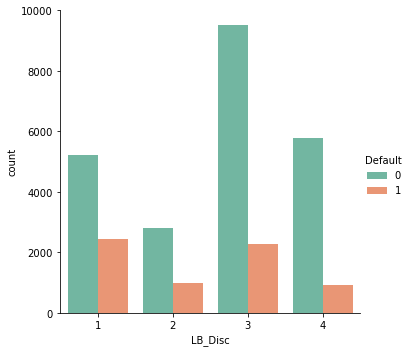

In [78]:
# Seaborn factor plot of Defaults by LB_Disc
sns.factorplot('LB_Disc', data=data, hue='Default', kind='count', palette='Set2');

It seems as Limit Balance increases the probability to Default actually decreases. 62% of credit loans are over 100,000 which are also the least probable to default. Loans under 60,000 have the highest probability to default.

In [80]:
data.dtypes

LIMIT_BAL        int64
SEX              int64
MARRIAGE         int64
AGE              int64
PAY_1            int64
PAY_2            int64
PAY_3            int64
PAY_4            int64
PAY_5            int64
PAY_6            int64
BILL_AMT1        int64
BILL_AMT2        int64
BILL_AMT3        int64
BILL_AMT4        int64
BILL_AMT5        int64
BILL_AMT6        int64
PAY_AMT1         int64
PAY_AMT2         int64
PAY_AMT3         int64
PAY_AMT4         int64
PAY_AMT5         int64
PAY_AMT6         int64
Default          int64
Grad School      int64
High School      int64
Edu_Other        int64
University       int64
SE_MA            int64
Age_Disc         int64
SE_AG            int64
BA1_2_LB       float64
LB_Disc          int64
dtype: object

In [81]:
# Correlation Matrix
data.corr()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,Default,Grad School,High School,Edu_Other,University,SE_MA,Age_Disc,SE_AG,BA1_2_LB,LB_Disc
LIMIT_BAL,1.000000,0.025015,-0.110953,0.144643,-0.170975,-0.197039,-0.191185,-0.180492,-0.169903,-0.167674,...,-0.153871,0.258512,-0.139583,0.013468,-0.147280,-0.013704,0.162151,0.101555,0.370054,0.868964
SEX,0.025015,1.000000,-0.028502,-0.091057,-0.034612,-0.044685,-0.041064,-0.039565,-0.038349,-0.031869,...,-0.039742,-0.022890,-0.007807,0.008502,0.025598,0.941236,-0.087862,0.875754,0.077492,0.067893
MARRIAGE,-0.110953,-0.028502,1.000000,-0.411733,-0.011592,-0.009365,0.002403,-0.003192,-0.002668,0.002628,...,-0.027259,0.136299,-0.092824,-0.009709,-0.059204,0.310786,-0.420550,-0.229986,-0.044757,-0.108690
AGE,0.144643,-0.091057,-0.411733,1.000000,-0.001401,-0.008783,-0.014171,-0.007167,-0.013141,-0.016816,...,0.013619,-0.100403,0.231322,0.008952,-0.077762,-0.225702,0.940494,0.372172,0.027251,0.121504
PAY_1,-0.170975,-0.034612,-0.011592,-0.001401,1.000000,0.698771,0.517209,0.460391,0.424593,0.373883,...,0.396200,-0.068575,0.042082,-0.025403,0.040742,-0.036829,-0.006297,-0.034837,-0.136920,-0.176445
PAY_2,-0.197039,-0.044685,-0.009365,-0.008783,0.698771,1.000000,0.663434,0.512599,0.462524,0.406853,...,0.327095,-0.083326,0.043769,-0.038228,0.056801,-0.045654,-0.012981,-0.047326,-0.177493,-0.206956
PAY_3,-0.191185,-0.041064,0.002403,-0.014171,0.517209,0.663434,1.000000,0.678639,0.551006,0.492344,...,0.286898,-0.071400,0.041765,-0.041327,0.047639,-0.038235,-0.016397,-0.045657,-0.117371,-0.201779
PAY_4,-0.180492,-0.039565,-0.003192,-0.007167,0.460391,0.512599,0.678639,1.000000,0.745171,0.602485,...,0.268937,-0.067921,0.039347,-0.036484,0.044898,-0.038700,-0.009881,-0.041123,-0.094874,-0.188957
PAY_5,-0.169903,-0.038349,-0.002668,-0.013141,0.424593,0.462524,0.551006,0.745171,1.000000,0.740088,...,0.260721,-0.057033,0.029220,-0.035144,0.041656,-0.037366,-0.017088,-0.043498,-0.086499,-0.174481
PAY_6,-0.167674,-0.031869,0.002628,-0.016816,0.373883,0.406853,0.492344,0.602485,0.740088,1.000000,...,0.244290,-0.046825,0.020000,-0.034644,0.038601,-0.029416,-0.021115,-0.039499,-0.079254,-0.168661


In [82]:
# Covariance Matrix
data.cov()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,Default,Grad School,High School,Edu_Other,University,SE_MA,Age_Disc,SE_AG,BA1_2_LB,LB_Disc
LIMIT_BAL,1.683769e+10,1587.661442,-7507.220718,173039.339301,-16877.873897,-20507.068684,-19615.745616,-17827.810601,-15824.401123,-15567.065145,...,-8288.039420,16026.234853,-6707.040936,216.698093,-9535.892010,-2744.236393,21724.737176,28075.382942,19757.129712,123648.180420
SEX,1.587661e+03,0.239246,-0.007269,-0.410621,-0.012879,-0.017530,-0.015882,-0.014731,-0.013464,-0.011153,...,-0.008069,-0.005349,-0.001414,0.000516,0.006248,0.710470,-0.044373,0.912613,0.015595,0.036416
MARRIAGE,-7.507221e+03,-0.007269,0.271890,-1.979329,-0.004598,-0.003917,0.000991,-0.001267,-0.000999,0.000980,...,-0.005900,0.033955,-0.017923,-0.000628,-0.015404,0.250083,-0.226416,-0.255493,-0.009602,-0.062149
AGE,1.730393e+05,-0.410621,-1.979329,84.998429,-0.009829,-0.064945,-0.103301,-0.050299,-0.086958,-0.110926,...,0.052121,-0.442245,0.789735,0.010233,-0.357724,-3.211192,8.952707,7.310223,0.103371,1.228398
PAY_1,-1.687787e+04,-0.012879,-0.004598,-0.009829,0.578744,0.426370,0.311113,0.266606,0.231846,0.203506,...,0.125116,-0.024924,0.011855,-0.002396,0.015465,-0.043237,-0.004946,-0.056464,-0.042858,-0.147196
PAY_2,-2.050707e+04,-0.017530,-0.003917,-0.064945,0.426370,0.643307,0.420743,0.312958,0.266274,0.233478,...,0.108902,-0.031930,0.013000,-0.003802,0.022732,-0.056508,-0.010750,-0.080871,-0.058574,-0.182026
PAY_3,-1.961575e+04,-0.015882,0.000991,-0.103301,0.311113,0.420743,0.625200,0.408458,0.312716,0.278533,...,0.094165,-0.026972,0.012229,-0.004052,0.018795,-0.046654,-0.013386,-0.076913,-0.038185,-0.174956
PAY_4,-1.782781e+04,-0.014731,-0.001267,-0.050299,0.266606,0.312958,0.408458,0.579426,0.407136,0.328129,...,0.084977,-0.024701,0.011091,-0.003444,0.017053,-0.045460,-0.007766,-0.066690,-0.029714,-0.157727
PAY_5,-1.582440e+04,-0.013464,-0.000999,-0.086958,0.231846,0.266274,0.312716,0.407136,0.515191,0.380073,...,0.077681,-0.019558,0.007766,-0.003128,0.014919,-0.041389,-0.012664,-0.066518,-0.025545,-0.137334
PAY_6,-1.556707e+04,-0.011153,0.000980,-0.110926,0.203506,0.233478,0.278533,0.328129,0.380073,0.511916,...,0.072554,-0.016006,0.005299,-0.003074,0.013781,-0.032479,-0.015598,-0.060210,-0.023331,-0.132330


I can see the variables I created didn't help much. The demographic variables have almost no correlation with default. I have a pretty good idea for what features to select for my predictive models. At this point, I will save the dataset to a csv file ready for model selection and validation.

In [83]:
# Save the dataset in a csv file
data.to_csv('Credit_Modeling.csv', index=False)

Summary of Findings:

Out of 29,965 loans, 6,630 defaulted or 22%. Loans with a credit limit under 60,000 are the issue, as 32% of these loans default. Customers under 29 and over 45 that are Not single and have an education level of High School have the highest probability to default on these loans. Other than the repayment status variables, the credit limit variable has the highest correlation with Default in the dataset, with a negative covariance. Surprisingly, this means as the credit limit increases default decreases. It appears the demographic variables will not be good predictors for default, as they have almost no correlation between them. It seems that customers are likely to default if Bill Amount 1 is close to their credit limit or Pay Amount 1 is too low to Bill Amount 2, although I already see some exceptions to this. I also observed that there are customers who duly paid their bill every month and still defaulted. Adding variables for Occupation, Income, Minimum Payment Due Each Month and Interest Rate (APR) might be helpful for future projects. Just from these observations, it appears that lowering the number of approved loans with a credit limit below 60,000 for customers under 29 years old, would lower the default rate significantly.